# Data Curation

The dataset I'll be working with can be found here

https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

In [ ]:
# ! pip install datasets
# ! pip show transformers
# ! pip install -U tokenizers

In [7]:
# imports
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath('..'))
from utils.items import Item

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting Environment Variables

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Loading and exploring the Data

Since this is a really big dataset I'll initially explore only one of the categories

In [ ]:
# Loadind and exploring the Appliances

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [10]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [11]:
# Investigate a particular datapoint
datapoint = dataset[2]


In [12]:
datapoint

{'main_category': 'Tools & Home Improvement',
 'title': 'Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504',
 'average_rating': 3.5,
 'rating_number': 18,
 'features': [],
 'description': ['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.'],
 'price': 'None',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/51TIpnkrEpL._AC_SL1500_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_US75_.jpg'],
  'variant': ['MAIN']},
 'videos': {'title': [], 'url': [], 'user_id': []},
 'store': 'GE',
 'categories': ['Appliances', 'Parts & Accessories'],
 'details': '{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Requi

In [13]:
# Investigate

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [14]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [15]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

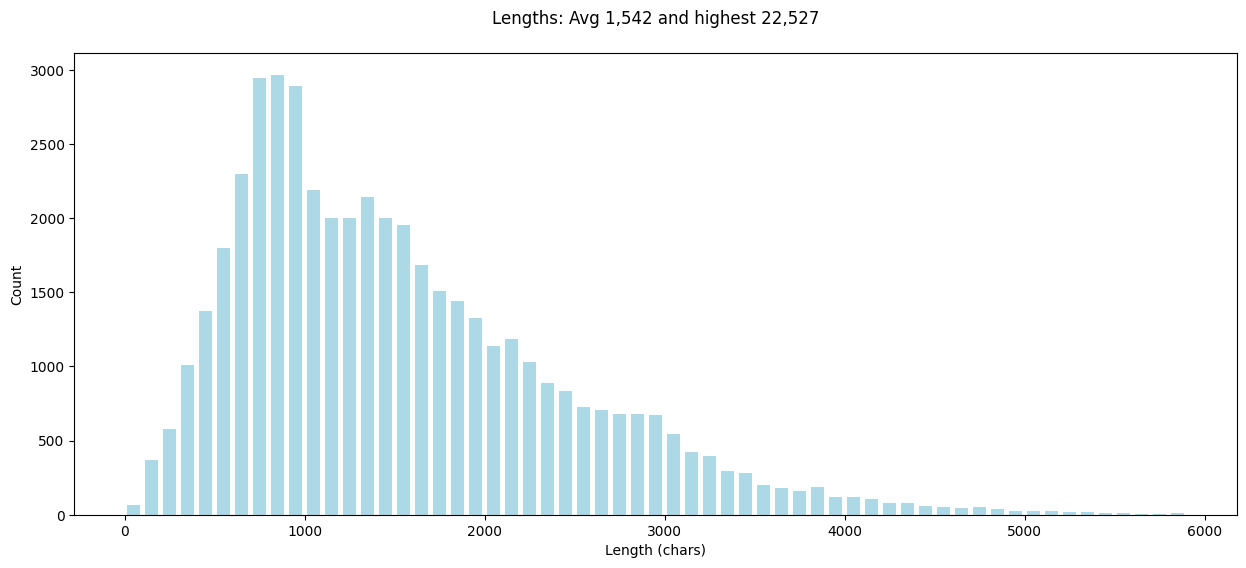

In [16]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

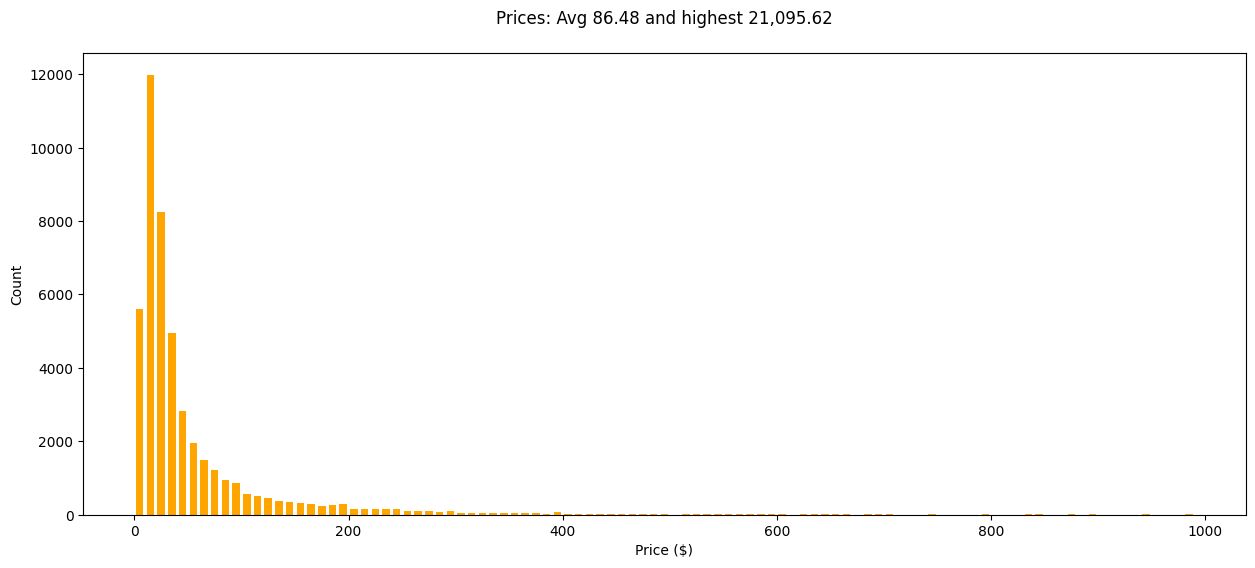

In [17]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In this section I will clean and crop the descriptions of the items so that they are all consistent and with an appropriate length.

In [20]:
dataset[0]

{'main_category': 'Industrial & Scientific',
 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)',
 'average_rating': 3.7,
 'rating_number': 61,
 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food',
  '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like',
  '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take 

In [19]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,229 items


In [30]:
# Look at the first item

print(items[0].details)

{"Brand Name": "AMI PARTS", "Model Info": "WD12X10327", "Item Weight": "0.634 ounces", "Item model number": "WD12X10327", "Part Number": "WD12X10327", "Color": "White", "Material Type": "Plastic", "Best Sellers Rank": {"Tools & Home Improvement": 65221, "Dishwasher Parts & Accessories": 181}, "Date First Available": "July 14, 2019", "Brand": "AMI PARTS", "Material": "Plastic", "Model Name": "WD12X10327 Rack Roller and stud assembly Kit", "Style": "WD12X10327 Rack Roller and stud assembly Kit"}


In [33]:
# Investigate the prompt that will be used during training - the model will learn to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

2-Pack Replacement for Samsung Refrigerator Water Filter - Compatible with Samsung HAF-CIN Fridge Water Filter Cartridge
This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure. Replacement for Filter Manufacturer Denali Pure, Part model number Is Discontinued No, Rank Tools & Home Improvement In-Refrigerator Water Filters 3632, Available May 27, 2015, Duration 6 \tmonths, External Testing Certification ANSI, NSF, Brand

Price is $22.00


In [34]:
# Investigate the prompt that will be used during testing

print(items[100].test_prompt())

How much does this cost to the nearest dollar?

2-Pack Replacement for Samsung Refrigerator Water Filter - Compatible with Samsung HAF-CIN Fridge Water Filter Cartridge
This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure. Replacement for Filter Manufacturer Denali Pure, Part model number Is Discontinued No, Rank Tools & Home Improvement In-Refrigerator Water Filters 3632, Available May 27, 2015, Duration 6 \tmonths, External Testing Certification ANSI, NSF, Brand

Price is $


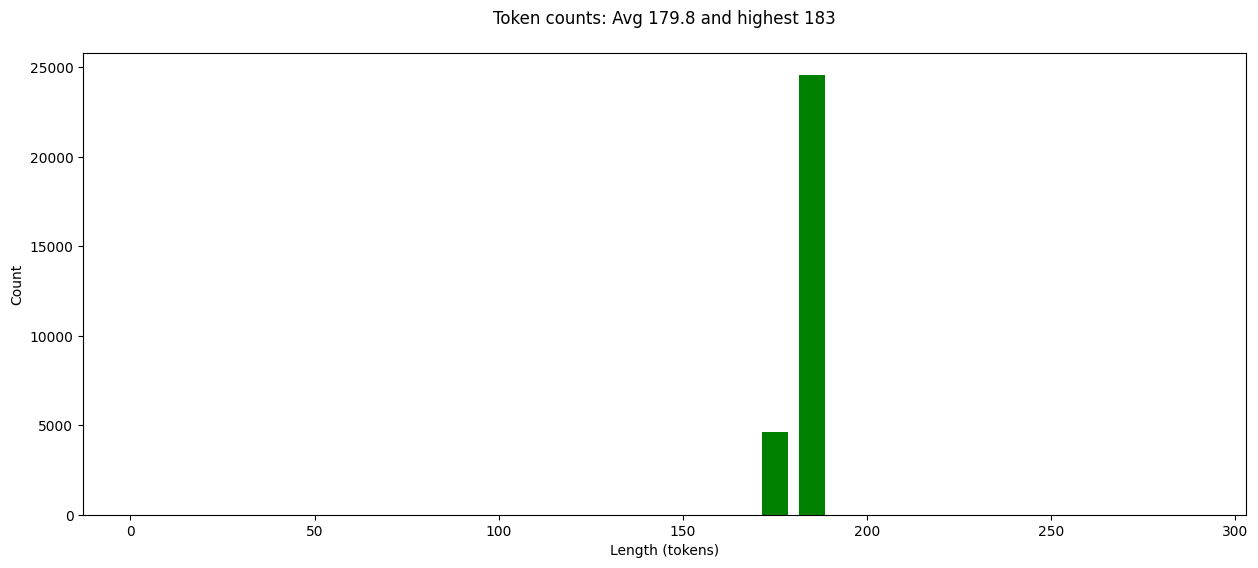

In [35]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

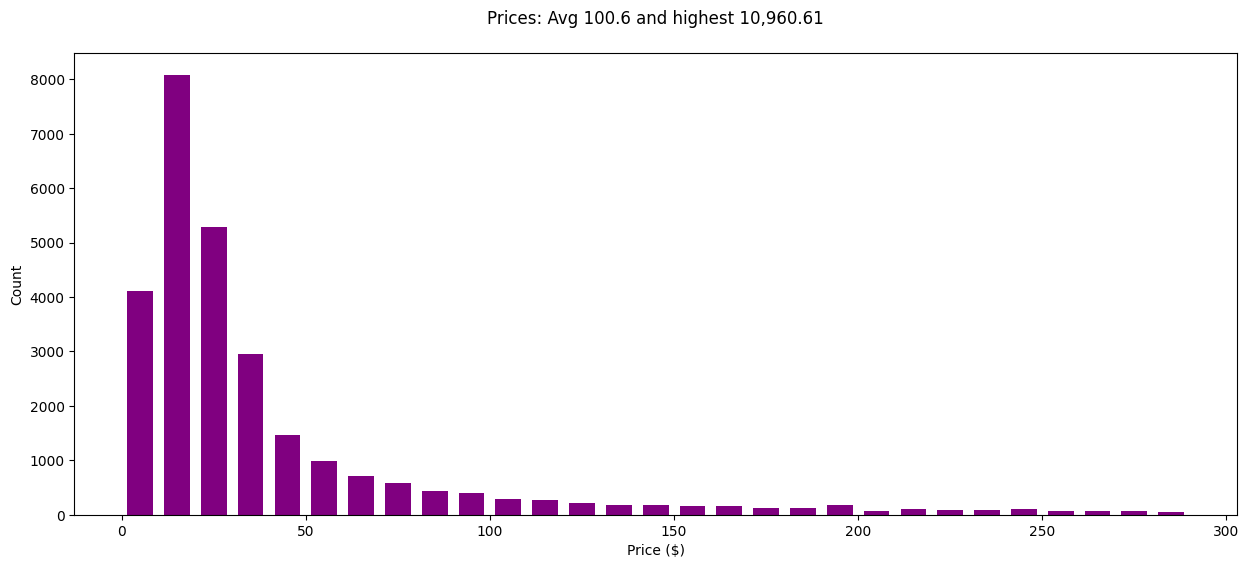

In [38]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()